# Importing Relevant Packages

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

# Function Definitions

In [2]:
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import StructureEstimator, BayesianEstimator, HillClimbSearch, PC, MmhcEstimator
from sklearn.preprocessing import LabelEncoder

class BayesianModel(BayesianNetwork):
    '''
    Wrapper class that gives pgmp's Bayesian Network class an interface that makes it compatible with
    scikit-learn. The object gets initialized with a graph search algorithm, an estimator for fitting 
    the network parameters, and the parameters needed for these two previously mentioned algorithms.
    '''

    def __init__(self, *, 
        ebunch=None,
        n_jobs = -1, 
        graph_search_algo=HillClimbSearch, 
        
        scoring_method='k2score', 
        start_dag=None, 
        fixed_edges=set(), 
        tabu_length=100, 
        max_indegree=None, 
        black_list=None, 
        white_list=None, 
        epsilon=0.0001, 
        max_iter=1000000.0, 
        show_progress=True, 

        variant='stable',
        ci_test='chi_square',
        max_cond_vars=5,
        return_type='dag',
        significance_level=0.01,

        estimator=BayesianEstimator, 
        prior_type='BDeu', 
        pseudo_counts=[], 
        equivalent_sample_size=5
        ):
        '''
        The initialization parameters are the graph search algorithm, the estimator used
        for finding the Table CPD parameters of each node, and the parameters needed for these 
        two previously mentioned algorithms.

        A lot of the parameters will not apply to the graph search alogrithm and
        estimator chosen. In that case, the default values should be left intact.
        '''        

        #Currently, the model cannot be initialized with a PDAG.
        if graph_search_algo == PC and return_type in ['pdag', 'cpdag']:
            raise ValueError('BayesianModel currently has no support for PDAG\'s')

        super().__init__(ebunch)
        
        #Parameters relevant to the HillClimbSearch graph search algorithm.
        self.ebunch = ebunch
        self.n_jobs = n_jobs
        self.graph_search_algo = graph_search_algo
        self.scoring_method = scoring_method
        self.start_dag = start_dag
        self.fixed_edges = fixed_edges
        self.tabu_length = tabu_length
        self.max_indegree = max_indegree
        self.black_list = black_list
        self.white_list = white_list
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.show_progress = show_progress

        #Parameters relevant to the PC graph search algorithm.
        self.variant = variant
        self.ci_test = ci_test
        self.max_cond_vars = max_cond_vars
        self.return_type = return_type
        self.significance_level = significance_level

        #Parameters related to the estimator used for finding the
        #Table CPD parameters of each node.
        self.estimator = estimator
        self.prior_type = prior_type
        self.pseudo_counts = pseudo_counts
        self.equivalent_sample_size = equivalent_sample_size

    def fit(self, X_train, y_train, **fit_params):
        '''
        Finds the graph and the Table CPD parameters of it.
        '''
        
        data = pd.concat([X_train, y_train], axis=1)
        
        graph_search_est = self.graph_search_algo(data)
        if self.graph_search_algo == HillClimbSearch:
            parameters = dict(
                scoring_method=self.scoring_method,
                start_dag=self.start_dag,
                fixed_edges=self.fixed_edges,
                tabu_length=self.tabu_length,
                max_indegree=self.max_indegree,
                black_list=self.black_list,
                white_list=self.white_list,
                epsilon=self.epsilon,
                max_iter=self.max_iter,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == PC:
            parameters = dict(
                variant=self.variant,
                ci_test=self.ci_test,
                max_cond_vars=self.max_cond_vars,
                return_type=self.return_type,
                significance_level=self.significance_level,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == MmhcEstimator:
            parameters = dict(
                scoring_method=self.scoring_method, 
                tabu_length=self.tabu_length, 
                significance_level=self.significance_level
            )

        #Run graph search algorithm to find the graph.
        dag = graph_search_est.estimate(**parameters)

        #Sometimes, there are columns that don't end up on the
        #found graph.
        extra_columns = list(set(data.columns) - set(dag.nodes))
        if y_train.name in extra_columns:
            raise ValueError('Resulting DAG does not contain target. It cannot be used to make predictions.')
        if len(extra_columns) > 0:
            data = data.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        self._dag = dag
        self.ebunch = list(dag.nodes)

        super().__init__(dag)
        print('Now fitting the graph...')
        
        #Finding the Table CPD parameters of the graph.
        super().fit(
            data, 
            estimator=self.estimator, 
            prior_type=self.prior_type, 
            pseudo_counts=self.pseudo_counts,
            equivalent_sample_size=self.equivalent_sample_size,
            n_jobs = self.n_jobs,
            **fit_params
        )
        print('Succesfully fitted the graph')

        self.X_ = X_train
        self.y_ = y_train
        self.fit_params_ = fit_params
        self.classes_ = LabelEncoder().fit(y_train).classes_

        return self

    def predict(self, X, stochastic=False, n_jobs=None):
        '''
        Given a dataframe with the features, predicts the values of
        the target.
        '''

        if n_jobs == None:
            n_jobs = self.n_jobs
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        y_pred_df = super().predict(X, stochastic, n_jobs)
        y_pred = y_pred_df.to_numpy()
        self.y_pred_ = y_pred

        return y_pred

    def predict_proba(self, X):
        '''
        Given a dataframe with the features, predicts the probability
        of each class of the target.
        '''

        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        y_pred_proba_df = super().predict_probability(X)
        y_pred_proba = y_pred_proba_df.to_numpy()
        self.y_pred_proba_ = y_pred_proba
        
        return y_pred_proba
    
    def get_params(self, deep=True):

        return {
            'ebunch':self.ebunch,
            'graph_search_algo':self.graph_search_algo,
            'scoring_method':self.scoring_method,
            'start_dag':self.start_dag,
            'fixed_edges':self.fixed_edges,
            'tabu_length':self.tabu_length,
            'max_indegree':self.max_indegree,
            'black_list':self.black_list,
            'white_list':self.white_list,
            'epsilon':self.epsilon,
            'max_iter':self.max_iter,
            'show_progress':self.show_progress,
            'variant':self.variant,
            'ci_test':self.ci_test,
            'max_cond_vars':self.max_cond_vars,
            'return_type':self.return_type,
            'significance_level':self.significance_level,
            'estimator':self.estimator,
            'prior_type':self.prior_type,
            'pseudo_counts':self.pseudo_counts,
            'equivalent_sample_size':self.equivalent_sample_size,
            'n_jobs':self.n_jobs
        }
    
    def set_params(self, **parameters):
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):
    '''
    Given an algorithm and a dictionary with its parameters, a list of scoring methods, a dataframe 
    of features, a target, a name for the algorithm, and possibly a resampler, applies cross-validation.
    It returns the dictionary of results returned by the sklearn function cross_validate, as well as a
    "summary" dictionary that contains the average values found on each cross-valicaton fold.
    '''

    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if resampler != None:
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={}, return_estimator=True)
    
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

In [4]:
def no_parents_black_list(list_orig, list_no_parents):
    '''Given a list of nodes, list_orig, and another list of nodes that should not have parents, 
    list_no_parents, generates the required black_list for use in graph search algorithms'''

    list_start = []
    list_end = []
    for node_no_parent in list_no_parents:
        list_temp_1 = list_orig.copy()
        list_temp_1.remove(node_no_parent)
        list_temp_2 = [node_no_parent] * len(list_temp_1)
        list_start.append(list_temp_1)
        list_end.append(list_temp_2)
    assert len(list_start) == len(list_end)
    
    black_list = []
    for i in range(len(list_start)):
        black_list = black_list + list(zip(list_start[i], list_end[i]))

    return black_list

In [5]:
from sklearn.metrics import roc_curve

def find_threshold(fpr_chosen, y_test, y_proba):
    '''
    Find the threshold value in the ROC curve given a desired
    false positive rate.
    '''

    fpr, _, thresholds= roc_curve(y_test, y_proba)
    indices = np.where(fpr <= fpr_chosen)[0]
    index = indices[-1:-2:-1][0] + 1
    return thresholds[index]

def predict_with_treshold(proba, threshold):
    '''
    For given probabilites and probability threshold, predict
    the class of the target.
    '''

    return (proba >= threshold).astype(float)

In [6]:
def value_counts(df, dropna=True):
    '''
    For each column in a dataframe, print the value counts.
    '''

    for column in df.columns:
        print(df[column].value_counts(dropna=dropna), '\n')

In [7]:
def drop_low_counts(df, threshold, ignored_columns=[], verbose=False):
    '''
    If a particular class of a feature happens too unfrequently, it might not appear 
    in both sets when using train-test split. This could cause problems for some 
    algorithms, such as the PC algorithms.

    This function finds feature classes that occur in the dataframe less than a given
    fraction of the total number of rows. It then drops all of the rows that contain
    at least one of these classes.
    '''
    
    #Initialize list of columns to ignore
    if isinstance(ignored_columns, str):
        ignored_columns = [ignored_columns]
    elif not isinstance(ignored_columns, list):
        raise TypeError('ignored_columns must be either str or list.')
    if verbose:
        if len(ignored_columns) == 0:
            print('No columns chosen to ignore')
        else:
            print('Columns to ignore:', *ignored_columns)
    n_rows = df.shape[0]

    #For each column not in ignored_columns, find values to drop
    to_drop = []
    for column in df.columns:
        if column not in ignored_columns:
            counts = df[column].value_counts(dropna=False)
            for value, count in counts.items():
                proportion = count / n_rows
                if proportion <= threshold:
                    to_drop.append((column, value))
    if len(to_drop) == 0:
        if verbose:
            print('No rows to drop')
        return df
    if verbose:
        print('Column-value pairs to drop:', *to_drop)

    #Find filter to use on the dataframe
    filter = np.array([False] * df.shape[0])
    for column, value in to_drop:
        filter = filter | (df[column] == value)
    drop_indices = df[filter].index
    df_new = df.drop(drop_indices).reset_index(drop=True)

    #Extra information to print out if verbose == True
    if verbose == True:
        n_rows_dropped = n_rows - df_new.shape[0]
        percent_dropped = round(n_rows_dropped / n_rows * 100, 2)
        print('Number of rows dropped:', n_rows_dropped)
        print('Percentage of rows dropped:', percent_dropped)

    return df_new

# Preparing the Data

Load the cleaned dataframe

In [8]:
with open('dataframe_clean.pkl', 'rb') as f:
    df = pickle.load(f)

In [9]:
df.columns

Index(['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol',
       'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat',
       'Education_Level', 'Income_Level', 'Smoker_Status', 'Heavy_Drinker',
       'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV',
       'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX',
       'Marital_Status', 'Sodium', 'Heart_Disease', 'Sample_Weights'],
      dtype='object')

To make the model simpler to interpret, only a few of the features will be included when building the graph. The most important ten features, according to calculated SHAP values, were chosen.

In [10]:
included_columns = ['Good_Health', 'Hypertension', 'High_Cholesterol', 'Smoker_Status', 'Age_Cat', 'Diabetes', 'Sodium', 'Heavy_Drinker', 'Heart_Disease', 'SEX', 'Sample_Weights']
df = df[included_columns]
df

,Good_Health,Hypertension,High_Cholesterol,Smoker_Status,Age_Cat,Diabetes,Sodium,Heavy_Drinker,Heart_Disease,SEX,Sample_Weights
0,2.0,1.0,1.0,3.0,5.0,2.0,999.0,2.0,0.0,2.0,341.384853
1,1.0,2.0,2.0,1.0,4.0,2.0,2.0,2.0,0.0,2.0,108.060903
3,2.0,1.0,1.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,341.384853
4,2.0,2.0,2.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,258.682223
5,1.0,1.0,2.0,4.0,6.0,2.0,2.0,2.0,0.0,2.0,256.518591
...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,1.0,1.0,4.0,6.0,1.0,1.0,2.0,0.0,2.0,531.980410
441452,1.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,2.0,746.416599
441453,2.0,1.0,1.0,3.0,6.0,2.0,999.0,2.0,0.0,2.0,207.663634
441454,1.0,1.0,2.0,4.0,4.0,2.0,1.0,2.0,0.0,1.0,515.758894


Change the values of the dataframe to string type. For reasons that are not known at the moment, integer and float values make the PC algorithm not run effectively.

In [11]:
df['Heart_Disease'] = df['Heart_Disease'].cat.remove_unused_categories()
df = df.astype(int).astype(str)

Separate the dataframe into a features dataframe and target series.

In [12]:
X = df.drop(columns=['Heart_Disease', 'Sample_Weights'])
y = df['Heart_Disease']

# Using Bayesian Networks as Classifiers

The following agorithms will construct Bayesian Network models from the data and them use them to predict the class of a target features. They involve two steps:  
    1. Learn the structure from the data (the directed acyclic graph, or DAG).  
    2. Fit the parameters of the probability distribution function implied by the found DAG.  

The algorithms for structure learning are divided into classes:  
    1. Score-based algorithms.  
    2. Contraint-based altorithms.  
    
Score-based algorithms make use of a score function that quantifies the degree to which a graph is consistent with the data. There are many such scoring functions. Constraint-based algorithms make use of hypothesis tests to test for independencies between the features conditional on other features. Since a DAG implies independence relations between the variables represented by the nodes, the results of these hypothesis tests can be used to construct the DAG. 

Creting the train and test sets. The training sets will also be randomly undersampled.

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

X_train_res, y_train_res = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

X_train_res.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train_res.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Creating a list of edges that are not allowed to appear when using the HillClimbSearch algorithm. Specifically, the node `SEX` and `Age_Cat` (age category) will not be allowed to have parents since it is obvious that the other features are not the direct causes of them.

In [14]:
black_list = no_parents_black_list(list(pd.concat([X, y], axis=1).columns), ['SEX', 'Age_Cat'])
black_list

[('Good_Health', 'SEX'),
 ('Hypertension', 'SEX'),
 ('High_Cholesterol', 'SEX'),
 ('Smoker_Status', 'SEX'),
 ('Age_Cat', 'SEX'),
 ('Diabetes', 'SEX'),
 ('Sodium', 'SEX'),
 ('Heavy_Drinker', 'SEX'),
 ('Heart_Disease', 'SEX'),
 ('Good_Health', 'Age_Cat'),
 ('Hypertension', 'Age_Cat'),
 ('High_Cholesterol', 'Age_Cat'),
 ('Smoker_Status', 'Age_Cat'),
 ('Diabetes', 'Age_Cat'),
 ('Sodium', 'Age_Cat'),
 ('Heavy_Drinker', 'Age_Cat'),
 ('SEX', 'Age_Cat'),
 ('Heart_Disease', 'Age_Cat')]

## Classification using HillClimbSearch

In [15]:
path = './bm_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import BayesianEstimator

    bm = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm.fit(X_train_res, y_train_res)
    y_pred = bm.predict(X_test)
    y_proba = bm.predict_proba(X_test)
    
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(bm, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ./bm_predictions.pkl.


### Results of Classification

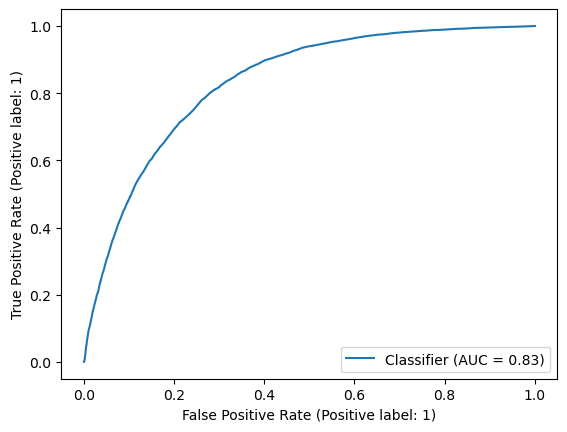

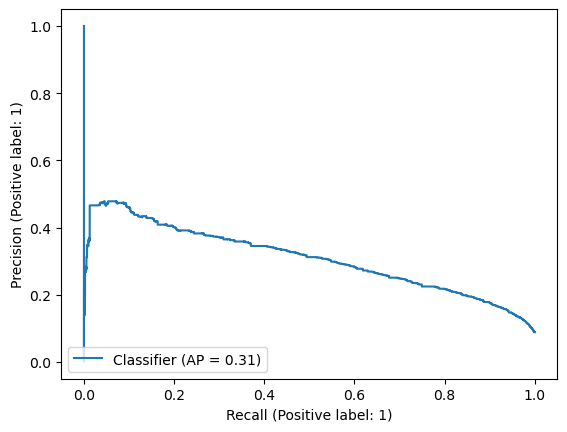

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     79776
           1       0.21      0.81      0.34      7727

    accuracy                           0.72     87503
   macro avg       0.59      0.76      0.58     87503
weighted avg       0.91      0.72      0.78     87503



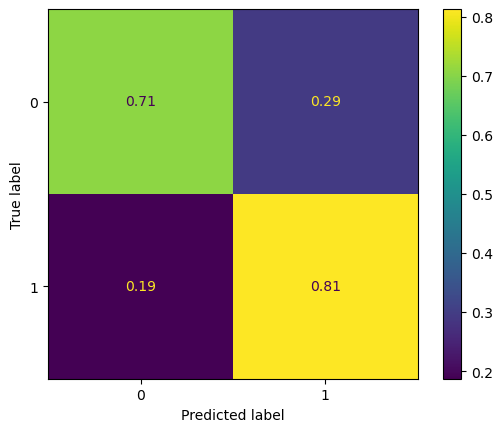

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

### DAG of the Model

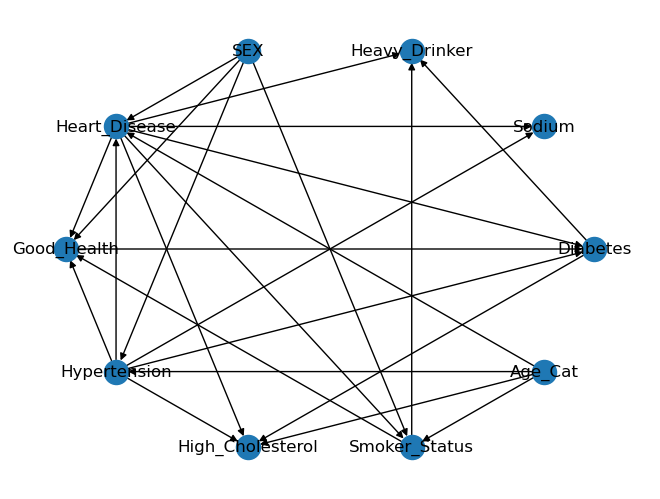

In [18]:
import networkx as nx

nx.draw_shell(bm, with_labels=True)

In [19]:
_, X_sample, _, y_sample = train_test_split(X, y, test_size=0.1, stratify=y)
X_sample = X_sample.reset_index(drop=True)
y_sample = y_sample.reset_index(drop=True)
temp_df = drop_low_counts(pd.concat([X_sample, y_sample], axis=1), 0.01, ignored_columns='Sample_Weight', verbose=True)
X_sample = temp_df.drop(columns='Heart_Disease')
y_sample = temp_df['Heart_Disease']
del(temp_df)
print('Number of columns in sampled dataframe:', X_sample.shape[0])

Columns to ignore: Sample_Weight
Column-value pairs to drop: ('Good_Health', '9') ('Hypertension', '9') ('High_Cholesterol', '9') ('Diabetes', '7') ('Diabetes', '9') ('Diabetes', '999') ('Sodium', '7') ('Sodium', '9')
Number of rows dropped: 652
Percentage of rows dropped: 1.49
Number of columns in sampled dataframe: 43100


## Classification using the PC algorithm

This project ran into a hurdle when using the constraint-based algorithm PC. The output of the algorithm should be a DAG, and, as implied by that name, should not have cycles. However, for reasons that are still not understood, the output of the algorithm consistently gives for our input data a DAG that contains a cylcle. This DAG is not accepted as a valid network as input to initialize a BayesianNetwork model, and, therefore, it cannot be used to make predictions. This might be due to a problem with the implementation of the algorithm in the pgmpy library.

An attempt was also made to find instead the Class PDAG (partial directed acyclic graph), which is a graph that represents an equivalent class of graphs that can all represent the conditional independencies found in the data. If there is a directed edge between two variables in all of the DAG's in the equivalence class and it is always in the same direction, then this edge will also be found in the Class PDAG. On the other hand, if the direction of an edge is not always the same in different DAGS in the equivalence class, then this edge will be undirected in the Class PDAG. 

When the PC algorithm was used to find the Class PDAG, the output was instead a proper DAG that had one cycle. As previously mentioned, if a directed graph has cycles, it cannot be used as a model to make predictions.

The source of this problem will be further inverstigated in the future.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

pc_algo = PC(pd.concat([X_train_res, y_train_res], axis=1))

In [ ]:
pc_dag = pc_algo.estimate(variant='orig', max_cond_vars=5, return_type='dag')

print('Found cycles:')
nx.find_cycle(pc_dag)

nx.draw_shell(pc_dag, with_labels=True)
plt.show()

In [ ]:
pc_cpdag = pc_algo.estimate(variant='orig', max_cond_vars=5, return_type='cpdag')

#Finding undirected edges
undir_edges = []
n_undir_edges = 0
edges = pc_cpdag.edges
for edge in edges:
    if (edge[1], edge[0]) in edges:
        n_undir_edges += 1
        undir_edges.append(edge)
print('Number of undirected edges:', n_undir_edges)
if len(undir_edges) != 0:
    print('Undirected edges:')
    for edge in undir_edges:
        print(edge)
    print()

#Finding cycles
print('Found cycles:')
nx.find_cycle(pc_cpdag)

nx.draw_shell(pc_cpdag, with_labels=True)
plt.show()

Model loaded


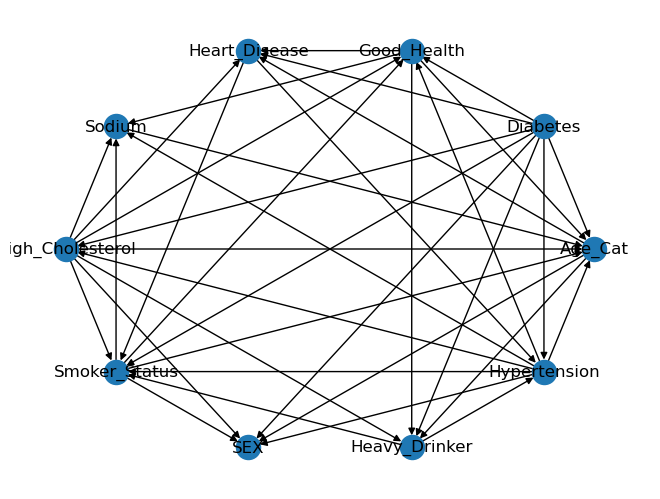

In [19]:
path = './cpdag.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        cpdag = pickle.load(f)
        print('Model loaded')
else:
    import networkx as nx
    import matplotlib.pyplot as plt
    import warnings

    warnings.filterwarnings('ignore', category=FutureWarning)

    test_pc = PC(pd.concat([X_sample, y_sample], axis=1))
    cpdag = test_pc.estimate(variant='orig', max_cond_vars=10, return_type='cpdag')
    print('Model trained')

    '''
    try:
        cycle = None
        cycle = nx.find_cycle(dag)
    except nx.exception.NetworkXNoCycle:
        print('No cycle found')
    else:
        print('Cycle found')
        print(cycle)help(
    '''

    with open('./pdag.pkl', 'wb') as f:
        pickle.dump(cpdag, f)

nx.draw_shell(cpdag, with_labels=True)
plt.show()
    
#bn = BayesianNetwork(dag)

In [21]:
nx.find_cycle(cpdag)

[('Smoker_Status', 'Sodium'),
 ('Sodium', 'Age_Cat'),
 ('Age_Cat', 'Heavy_Drinker'),
 ('Heavy_Drinker', 'Smoker_Status')]

In [22]:
from pgmpy.estimators import BayesianEstimator
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from sklearn.model_selection import StratifiedKFold

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
recall_scorer = make_scorer(recall_score, pos_label='1')

In [23]:
print(X.shape, y.shape)
temp_df = drop_low_counts(pd.concat([X, y], axis=1), 0.01, verbose=True)
X = temp_df.drop(columns='Heart_Disease')
y = temp_df['Heart_Disease']
del(temp_df)
print(X.shape, y.shape)

(437514, 9) (437514,)
No columns chosen to ignore
Column-value pairs to drop: ('Good_Health', '9') ('Hypertension', '9') ('High_Cholesterol', '9') ('Diabetes', '7') ('Diabetes', '9') ('Diabetes', '999') ('Sodium', '7') ('Sodium', '9')
Number of rows dropped: 6334
Percentage of rows dropped: 1.45
(431180, 9) (431180,)


## Classification using the Mmhc Algorithm

The Mmhc algorithm is a combination of both the score-based and constraint-based approach to structure learning. A contraint-based approach is used to first find the skeleton of the graph, which is the graph were all of the edges are directed. Then, it uses scoring functions to orient the edges in a way that maximizes the score.

In [15]:
path = './bm_mmhc_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm_mmhc = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import BayesianEstimator
    import warnings

    warnings.filterwarnings('ignore', category=FutureWarning)

    bm_mmhc = BayesianModel(graph_search_algo=MmhcEstimator, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm_mmhc.fit(X_train_res, y_train_res)
    y_pred = bm_mmhc.predict(X_test)
    y_proba = bm_mmhc.predict_proba(X_test)
    
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(bm_mmhc, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/4475 [00:00<?, ?it/s]

Model trained.


### Results of Classification

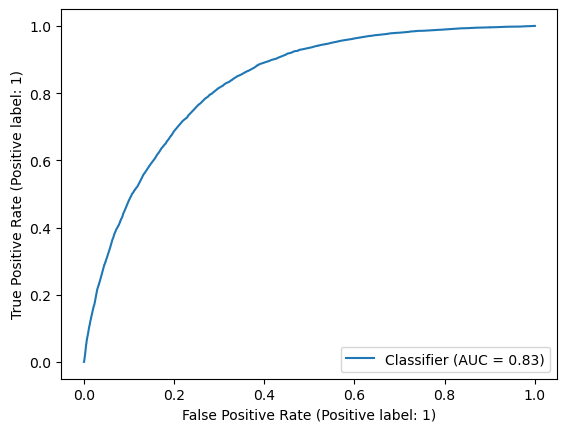

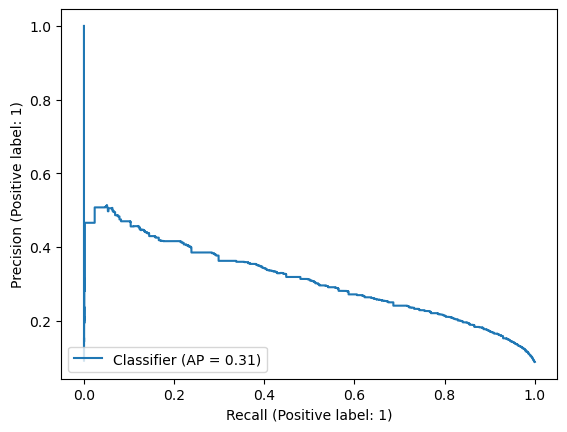

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     79776
           1       0.21      0.80      0.34      7727

    accuracy                           0.72     87503
   macro avg       0.59      0.76      0.58     87503
weighted avg       0.91      0.72      0.78     87503



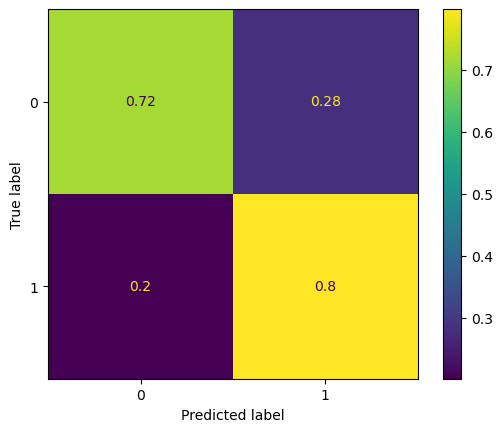

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

### DAG of the Model

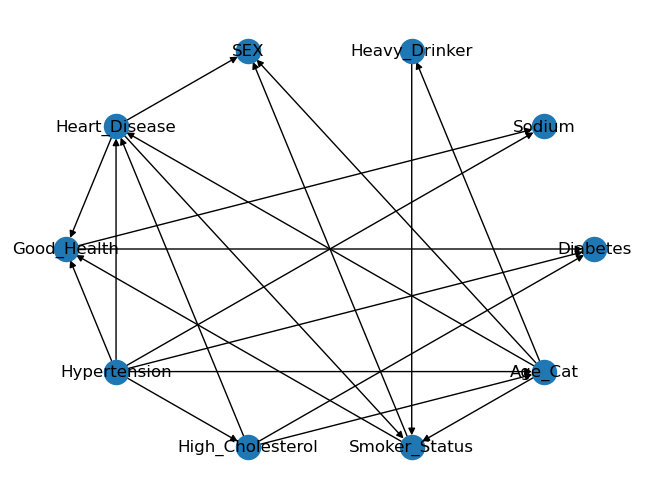

In [18]:
import networkx as nx

nx.draw_shell(bm_mmhc, with_labels=True)

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

path = './cv_scores_Mmhc.pkl'
if not os.path.exists(path):
    cv_scores_summary, cv_scores = cv_scorer(BayesianModel, {'recall':recall_scorer, 'roc_auc':roc_auc_scorer}, X, y, model_name='BayesianModel', 
                                                algo_params=dict(
                                                    graph_search_algo=MmhcEstimator, 
                                                    estimator=BayesianEstimator, 
                                                    prior_type='BDeu', 
                                                    equivalent_sample_size=5
                                                ), 
                                                resampler=RandomUnderSampler, output=True
                                            )
    
    with open('./cv_scores_Mmhc.pkl', 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(cv_scores_summary, f)
        pickle.dump(cv_scores, f)
else:
    print('Skip block')

Skip block


In [25]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

path = 'cv_scores_BayesianModel.pkl'
if not os.path.exists(path):
    cv_scores_summary, cv_scores = cv_scorer(BayesianModel, {'recall':recall_scorer, 'roc_auc':roc_auc_scorer}, X, y, model_name='BayesianModel', 
                                                algo_params=dict(
                                                    graph_search_algo=HillClimbSearch, 
                                                    estimator=BayesianEstimator, 
                                                    prior_type='BDeu', 
                                                    equivalent_sample_size=5
                                                ), 
                                                resampler=RandomUnderSampler, output=True
                                            )
        
    with open('./cv_scores_BayesianModel.pkl', 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(cv_scores_summary, f)
        pickle.dump(cv_scores, f)
else:
    print('Skip block')

Skip block


# Inference

In [26]:
temp_df = drop_low_counts(pd.concat([X, y], axis=1), 0.01, verbose=True)
X_drop = temp_df.drop(columns='Heart_Disease')
y_drop = temp_df['Heart_Disease']
del(temp_df)

No columns chosen to ignore
No rows to drop


In [27]:
path = './inference_model.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        inference_model = pickle.load(f)
        print('Loaded model')
else:
    inference_model = BayesianModel(graph_search_algo=HillClimbSearch, black_list=black_list, estimator=BayesianEstimator).fit(X_drop, y_drop)
    print('Model trained')
    with open('./inference_model.pkl', 'wb') as f:
        pickle.dump(inference_model, f)

Loaded model


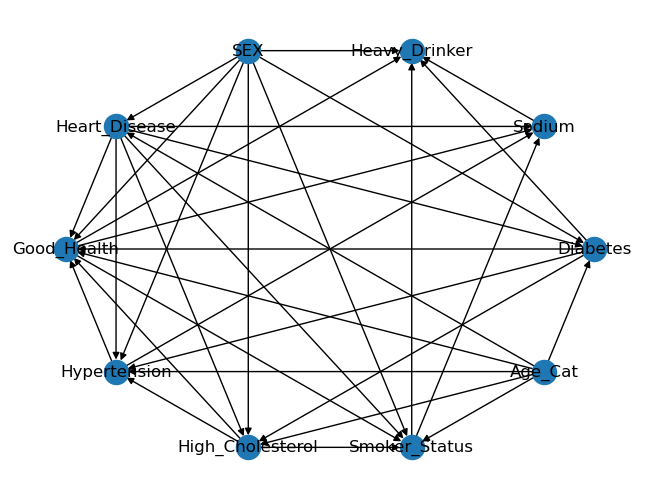

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw_shell(inference_model, with_labels=True)
plt.show()

In [29]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(inference_model)

In [66]:
def discrete_factor_to_series(factor, name=None):
    variables = factor.scope()
    n_states = 1
    for cardinality in factor.get_cardinality(variables).values():
        n_states = n_states * cardinality
    state_indices = list(range(n_states))
    assignments = factor.assignment(state_indices)
    state_names = []
    for assignment in assignments:
        state_name = ''
        for i, tuple_ in enumerate(assignment):
            if i != 0:
                state_name = state_name + '__'
            state_name = state_name + tuple_[0] + '_' + tuple_[1]
        state_names.append(state_name)
    states_dicts = [{state[0]:state[1] for state in assignment} for assignment in assignments]
    values = [round(factor.get_value(**dict_), 4) for dict_ in states_dicts]

    return pd.Series(values, index=state_names, name=name)

In [95]:
path = './inference_results.pkl'
if not os.path.exists(path):
    X_ = vars(inference)['model'].X_
    y_ = vars(inference)['model'].y_
    df_ = pd.concat([X_, y_], axis=1)
    features = df_.columns

    inference_results = {}

    for feature in df_.columns:
        predecessors_states = {}
        for predecessor in inference_model.predecessors(feature):
            predecessors_states[predecessor]= list(df_[predecessor].unique())

        phi = {}
        phi['No_intervention'] = inference.query([feature])
        for predecessor, states in predecessors_states.items():
            for value in states:
                name = f'{predecessor}_{value}'
                phi[name] = inference.query([feature], do={predecessor:value})

        series_list = []
        for name, factor in phi.items():
            series_list.append(discrete_factor_to_series(factor, name))
    
        infer_df = pd.DataFrame()
        columns = []
        for series in series_list:
            columns.append(series.name)
            infer_df = pd.concat([infer_df, series], axis=1)
        infer_df.columns = columns
        infer_df = infer_df.T
    
        inference_results[feature] = infer_df

    for feature, df in inference_results.items():
        for column in df.columns:
            base_value = df[column][0]
            new_column = df[column] - base_value
            new_column_name = column + '_diff'
            insert_index = df.columns.get_loc(column) + 1
            df.insert(insert_index, new_column_name, new_column)
        inference_results[feature] = df

    with open(path, 'wb') as f:
        pickle.dump(inference_results, f)

else:
    with open(path, 'rb') as f:
        inference_results = pickle.load(f)
    print('Loaded inference results')

Loaded inference results


In [97]:
for df in inference_results.values():
    print(df)
    print()

                      Good_Health_1  Good_Health_1_diff  Good_Health_2  \
No_intervention              0.8165              0.0000         0.1835   
Hypertension_1               0.7532             -0.0633         0.2468   
Hypertension_2               0.8553              0.0388         0.1447   
High_Cholesterol_1           0.7843             -0.0322         0.2157   
High_Cholesterol_2           0.8434              0.0269         0.1566   
High_Cholesterol_999         0.7558             -0.0607         0.2442   
Age_Cat_5                    0.7897             -0.0268         0.2103   
Age_Cat_4                    0.8222              0.0057         0.1778   
Age_Cat_6                    0.7700             -0.0465         0.2300   
Age_Cat_3                    0.8747              0.0582         0.1253   
Age_Cat_2                    0.9027              0.0862         0.0973   
Age_Cat_1                    0.9219              0.1054         0.0781   
Diabetes_2                   0.8455   

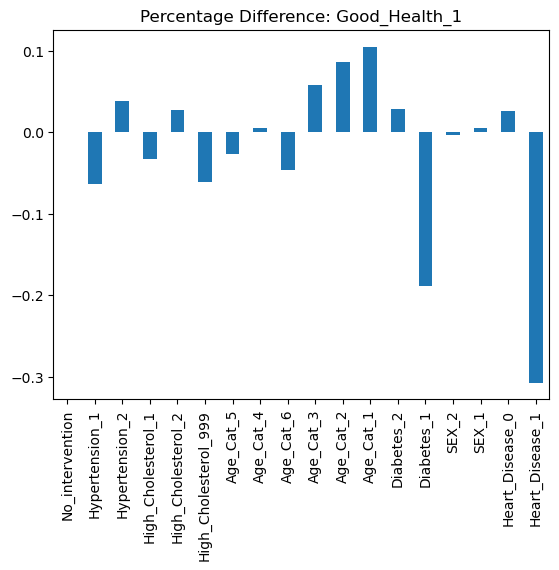

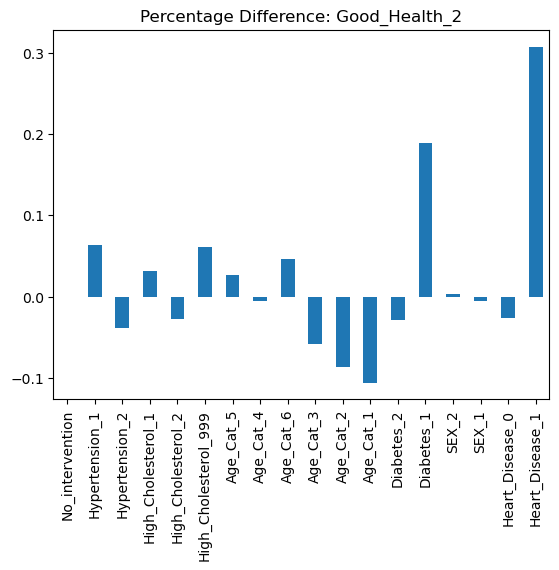

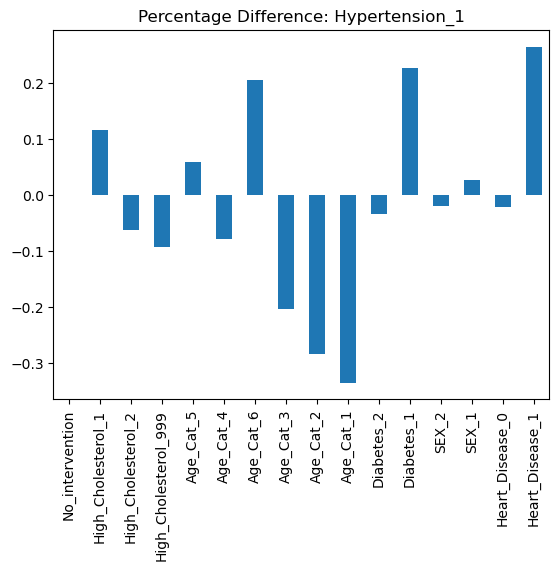

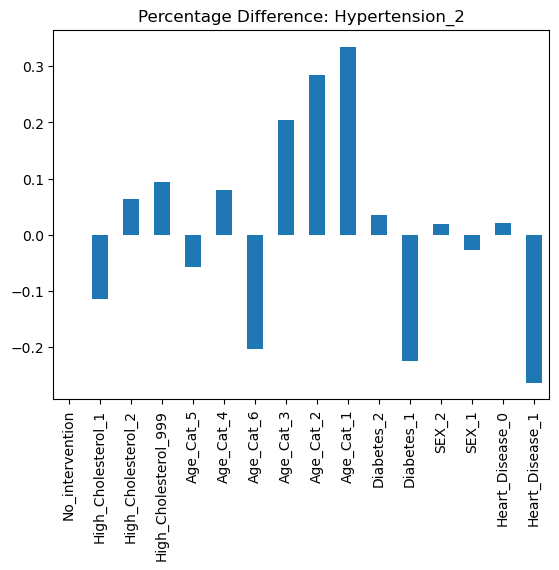

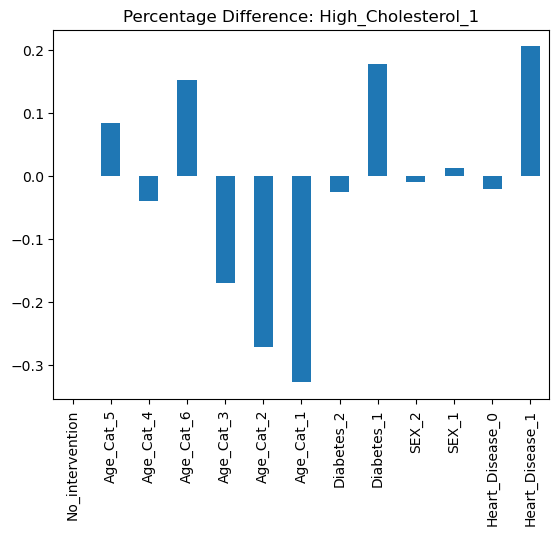

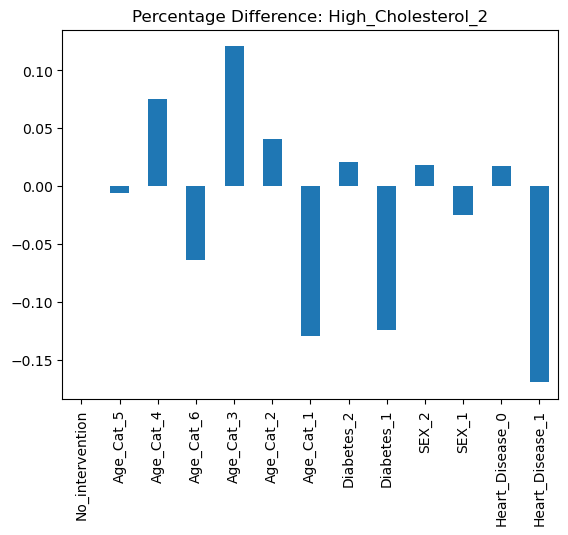

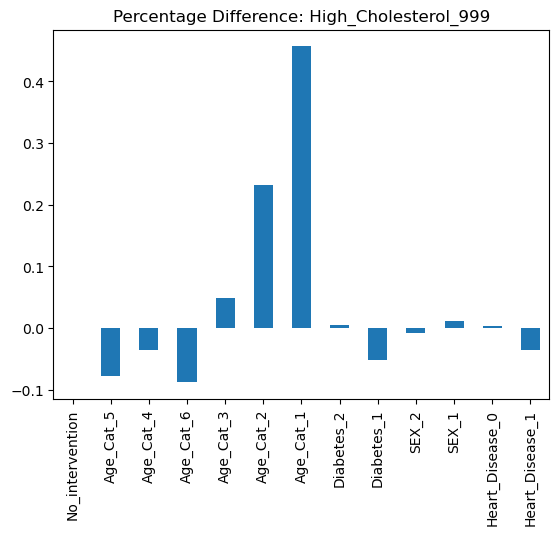

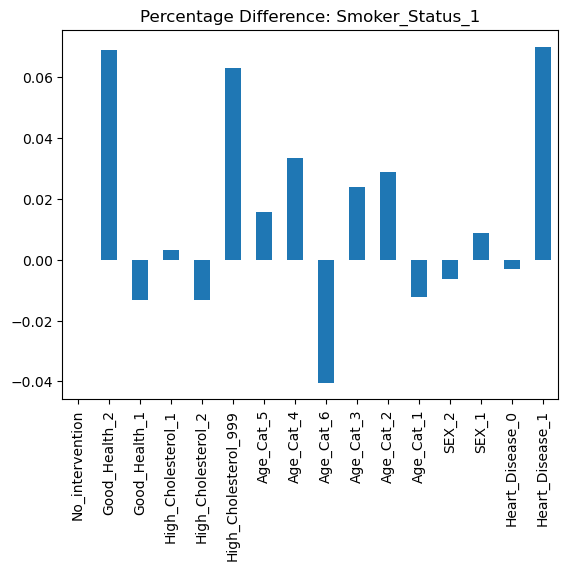

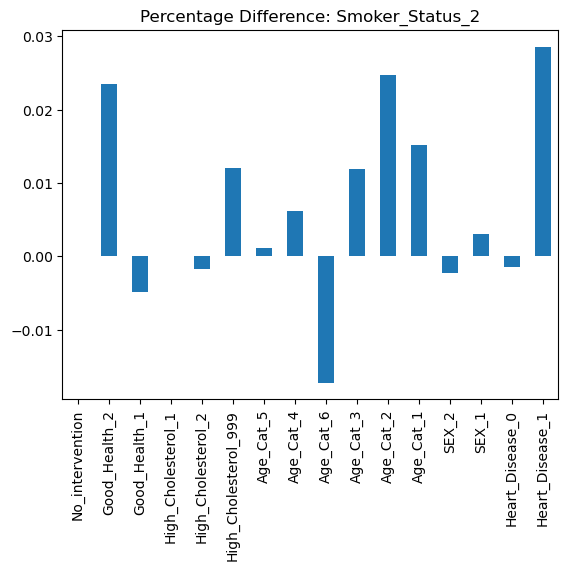

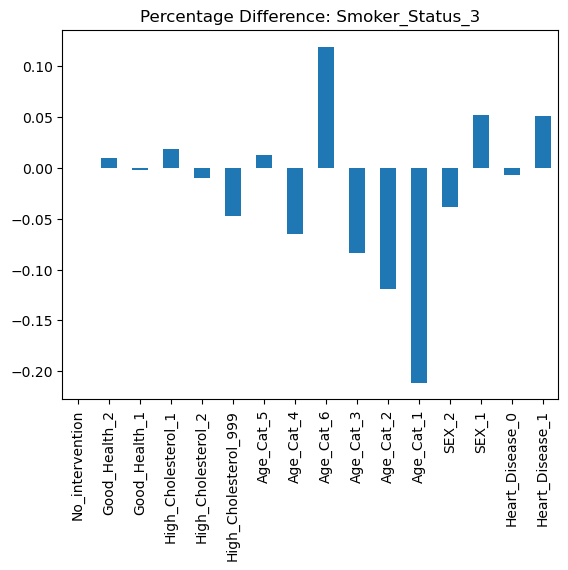

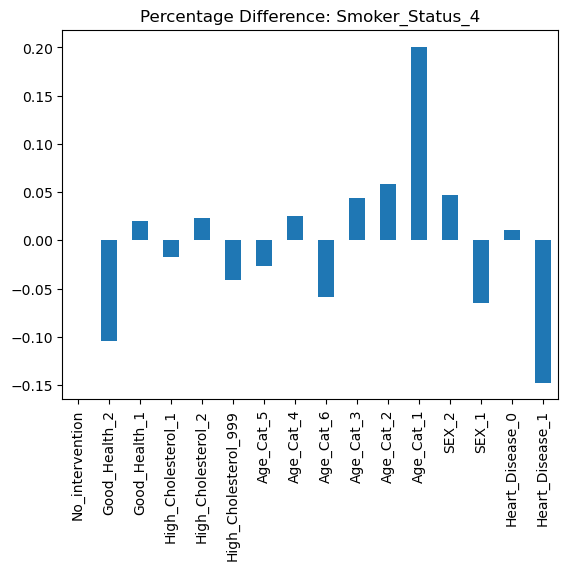

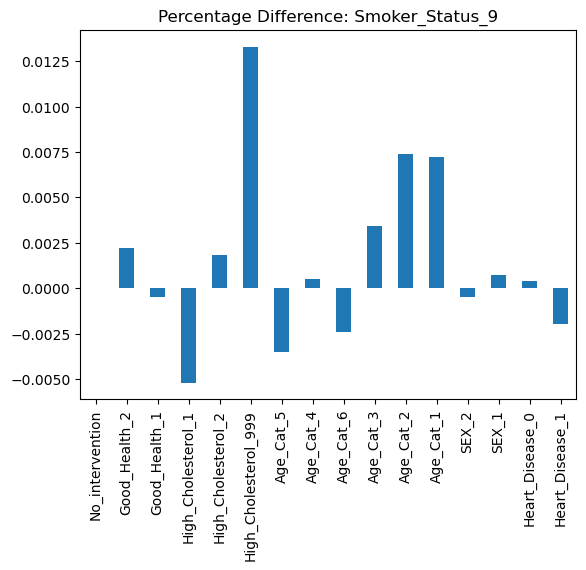

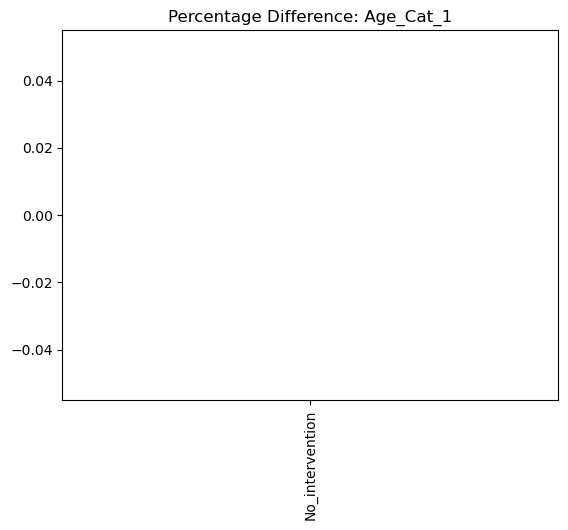

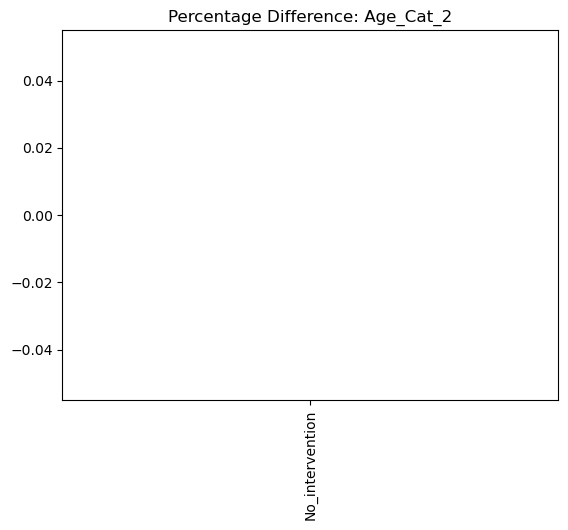

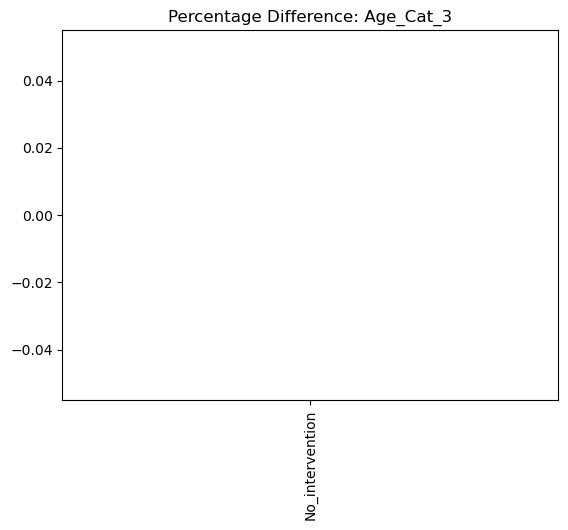

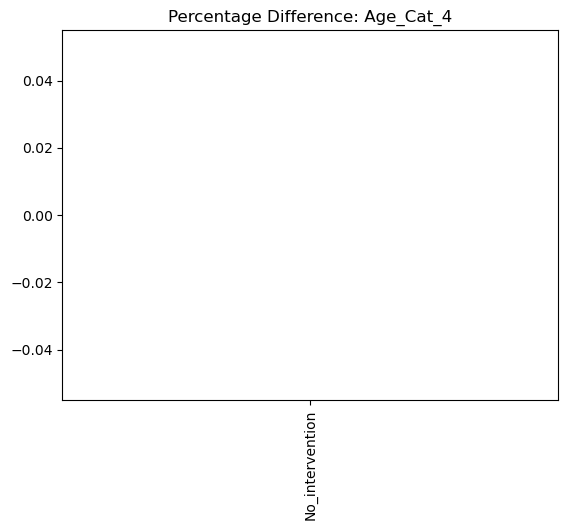

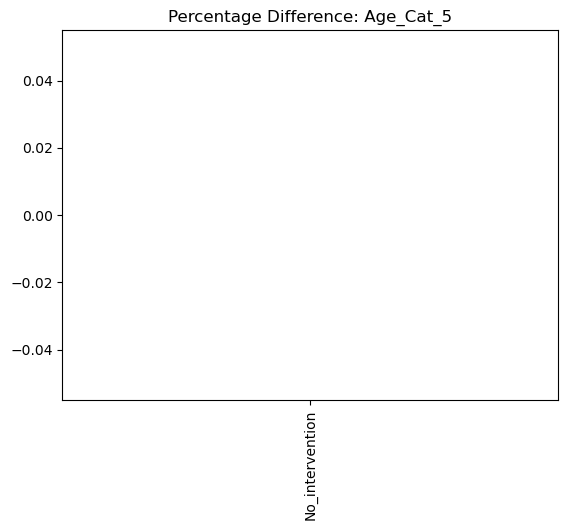

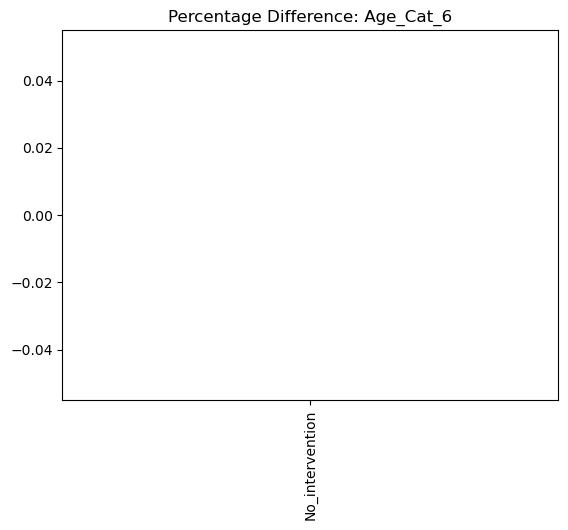

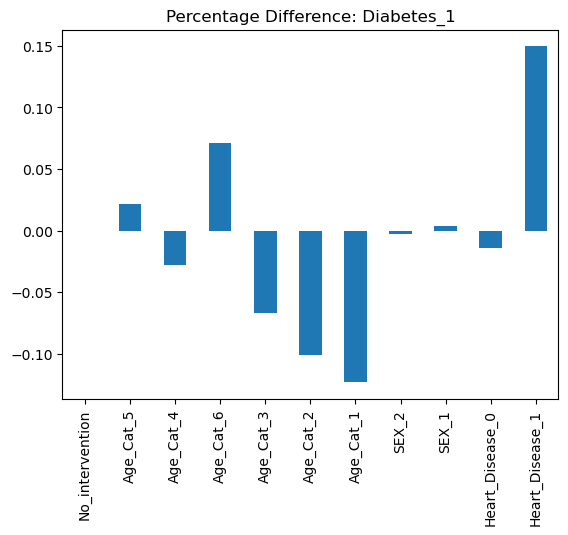

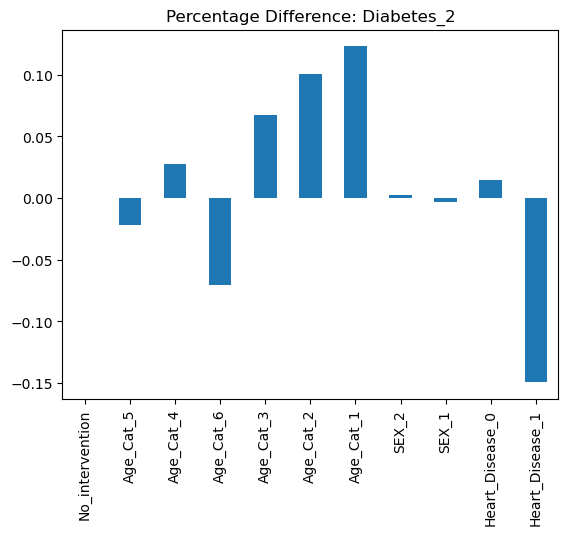

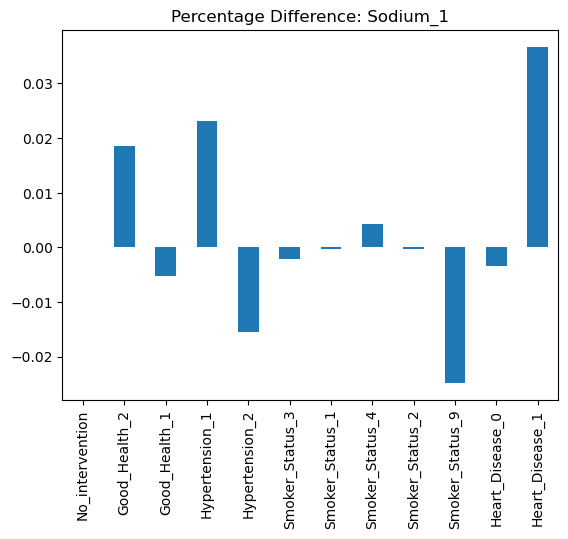

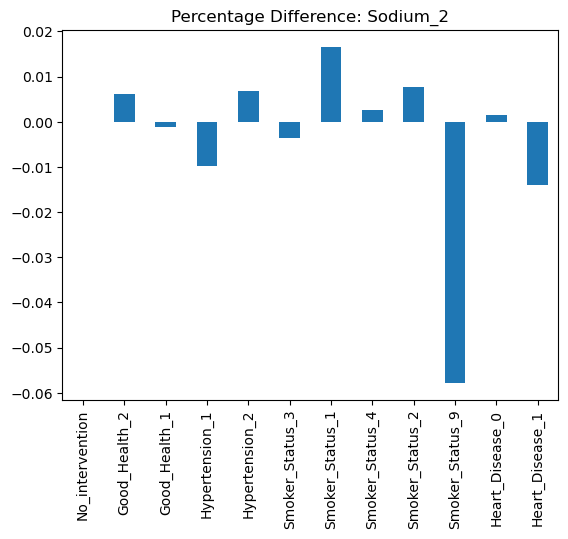

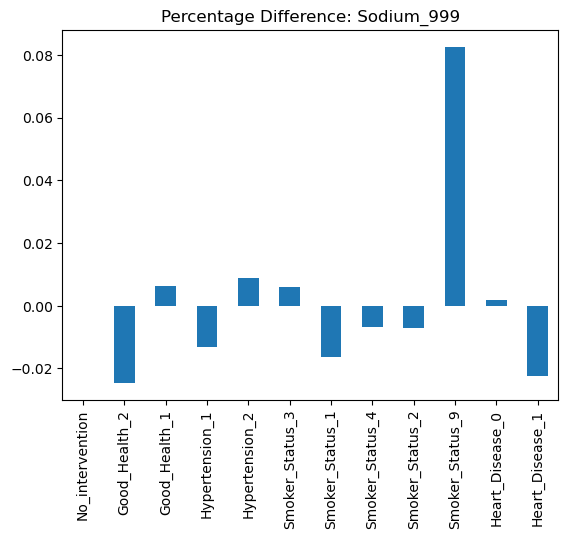

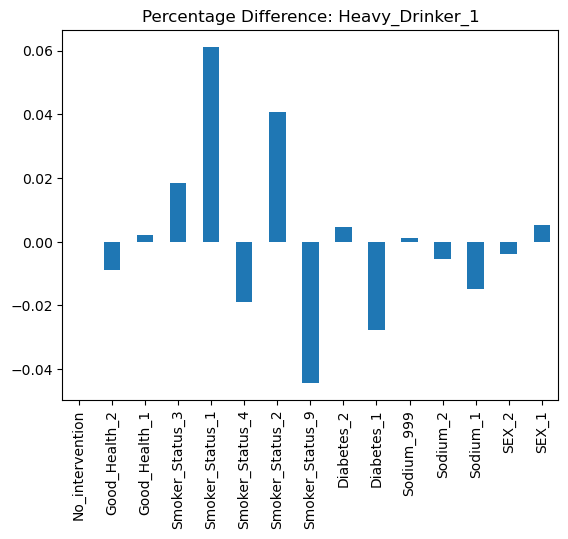

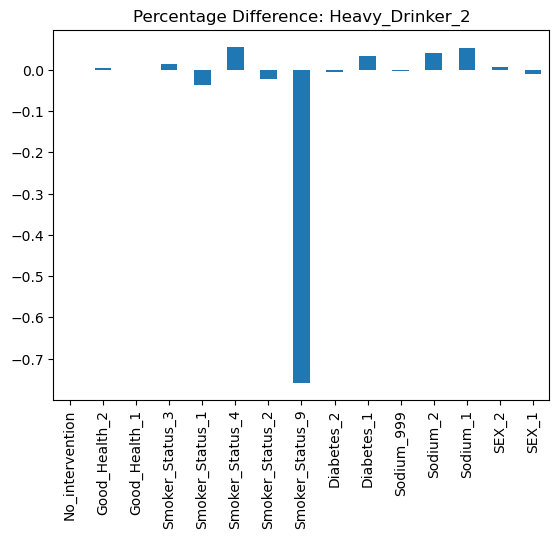

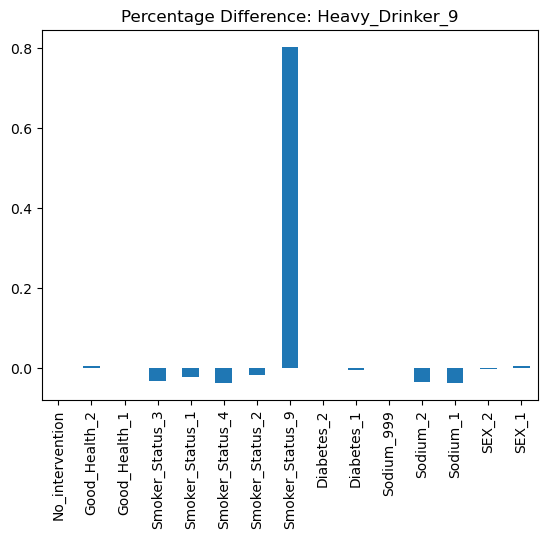

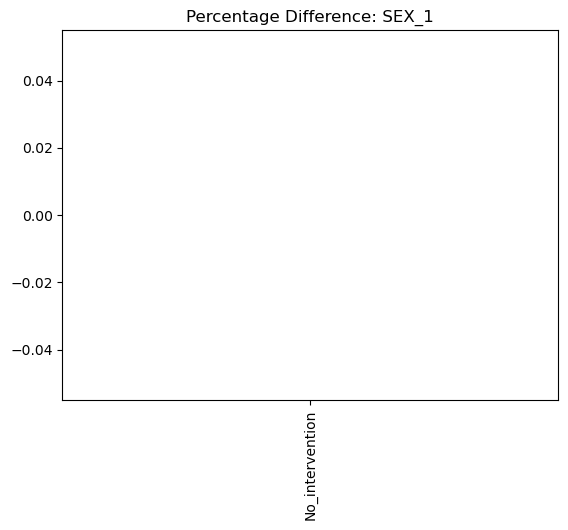

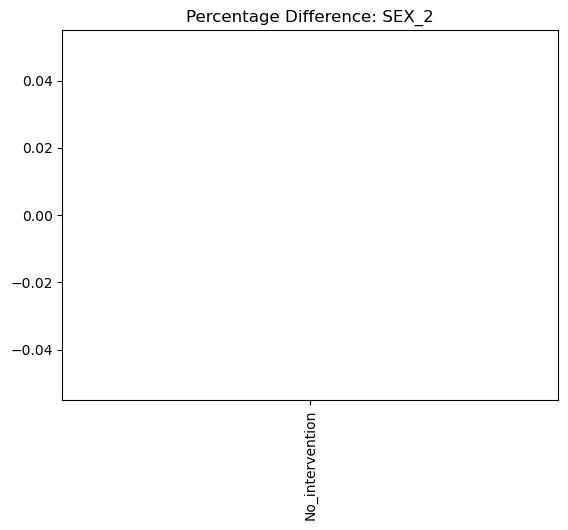

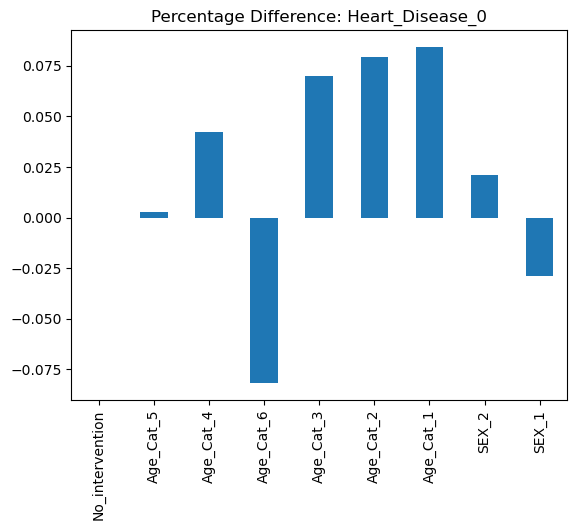

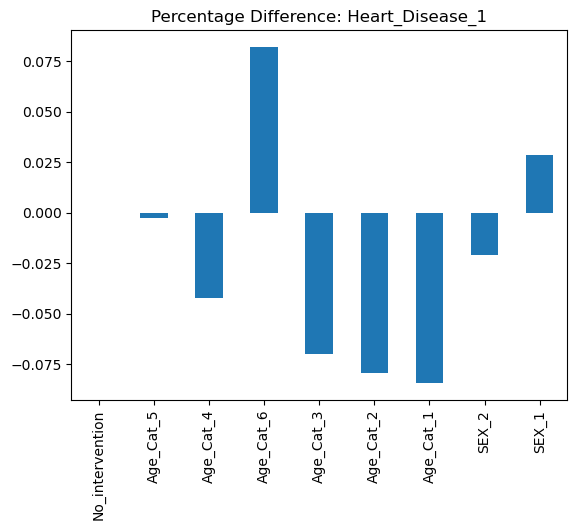

In [113]:
for df in inference_results.values():
    columns = df.columns
    n_columns = len(columns)
    for i in range(1, n_columns, 2):
        df.iloc[:, i].plot.bar()
        plt.title('Percentage Difference: ' + columns[i - 1])
        plt.show()


**Testing Active Trail Function**

In [ ]:
toy_model = BayesianNetwork([('Difficulty', 'Grade'), ('Intelligence', 'Grade'),('Intelligence', 'SAT'), ('Grade', 'Letter')])

In [ ]:
toy_model.get_random_cpds(n_states = {'Difficulty':2, 'Intelligence':2, 'Grade':5, 'SAT':2, 'Letter':2}, inplace=True)

In [ ]:
help(BayesianNetwork)

In [ ]:
nx.draw_kamada_kawai(toy_model, with_labels=True)

In [ ]:
for node in toy_model.nodes:
    print(toy_model.active_trail_nodes(node, []))

In [ ]:
toy_model.nodes

In [ ]:
toy_model.states

In [ ]:
df_toy = pd.DataFrame(index=[0])

In [ ]:
df_toy

In [ ]:
toy_model.predict_probability(df_toy)

In [ ]:
toy_model.active_trail_nodes(['SAT'])